### This notebook loads a trained model and deploys it using the appropriate test dataset

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.insert(1, '/home/kseuro/Kai/deeplearnphysics/pytorch/particle_generator/')

# My stuff
import ae
import conv_ae
import utils
from dataloader import LArCV_loader

In [3]:
# Set the root path of the particle generator experiments folder
exp_root = "/media/hdd1/kai/particle_generator/experiments/"

In [4]:
# Set the model type folder (either MLP or Conv model)
model_folder = "larcv_ae/" + "conv_ae/"

In [5]:
# Update the exp_root
exp_root += model_folder

In [6]:
# Get the names of all the experiments in the exp_root folder
exp_paths = []
for path in os.listdir(exp_root):
    exp_paths.append(os.path.join(exp_root, path))

print("-"*60)
for i in range(len(exp_paths)):
    print("\n Exp_{}:".format(str(i)), exp_paths[i], '\n')
    print("-"*60)

------------------------------------------------------------

 Exp_0: /media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_1000-epochs 

------------------------------------------------------------


In [7]:
# Set the dir of the particular experiment to be deployed
exp_dir = exp_paths[0]

In [8]:
# Create the full path to the experiment
exp_path = os.path.join(exp_root, exp_dir) + "/"
print("Experiment path set as: \n{}".format(exp_path))

Experiment path set as: 
/media/hdd1/kai/particle_generator/experiments/larcv_ae/conv_ae/conv_ae_64_1000-epochs/


In [9]:
# Load the config csv as a dict
config_csv = exp_path + "config.csv"
config_df = pd.read_csv(config_csv, delimiter = ",")

In [10]:
# Get the model architecture from config df
n_layers = int(config_df[config_df['Unnamed: 0'].str.contains("n_layers")==True]['0'].values.item())
l_dim    = int(config_df[config_df['Unnamed: 0'].str.contains("l_dim")==True]['0'].values.item())
im_size  = int(config_df[config_df['Unnamed: 0'].str.contains("dataset")==True]['0'].values.item())**2
depth    = int(config_df[config_df['Unnamed: 0'].str.contains("depth")==True]['0'].values.item())
im_dim   = int(np.sqrt(im_size))

In [11]:
# Path to model weights
weights_dir = "weights/"

In [12]:
# Path to the test data
test_data = "/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_{}/".format(im_dim)
print("Test data will be loaded from: \n{}".format(test_data))

Test data will be loaded from: 
/media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


In [13]:
# Set up the torch dataloader
loader_kwargs = {'num_workers' : 2, 'batch_size': 1, 'shuffle': True}
test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5],[0.5])])
test_dataset    = LArCV_loader(root = test_data, transforms = test_transforms)

Image conversion flag is: L
Images will be loaded from subfolder of: /media/hdd1/kai/particle_generator/larcv_data/test/larcv_png_64/


In [14]:
dataloader = DataLoader(test_dataset, **loader_kwargs)

In [15]:
# Set the GPU (GPU 1 is the best option)
device = torch.device(2)

## Set up AutoEncoder Layers

In [16]:
# Set up AE layer sizes
if 'mlp' in exp_path:
    base = [256] 

    # Compute encoder sizes
    sizes = lambda: [ (yield 2**i) for i in range(n_layers) ]
    enc_sizes = base * n_layers
    enc_sizes = [a*b for a,b in zip(enc_sizes, [*sizes()])][::-1]

    # Update kwarg dicts
    # Decoder is the reverse of the encoder
    ae_kwargs = {'enc_sizes' : enc_sizes, 'l_dim' : l_dim, 'im_size' : im_size, 'dec_sizes' : enc_sizes[::-1]}
else:
    depth   = [depth] * n_layers
    divisor = lambda: [ (yield 2**i) for i in range(n_layers) ]
    depth   = [a//b for a,b in zip(depth, [*divisor()])][::-1]
    ae_kwargs = {'enc_depth' : depth, 'dec_depth' : depth[::-1] }

In [17]:
# Get checkpoint name(s)
checkpoint_path  = exp_path + weights_dir
checkpoint_names = []
for file in os.listdir(checkpoint_path):
    checkpoint_names.append(os.path.join(checkpoint_path, file))

In [18]:
print("-"*60)
for i in range(len(checkpoint_names)):
    name = checkpoint_names[i].split('/')[-1]
    print("\n{}:".format(str(i)), name, '\n')
    print("-"*60)

------------------------------------------------------------

0: best_conv_ae_ep_650.tar 

------------------------------------------------------------

1: best_conv_ae_ep_600.tar 

------------------------------------------------------------

2: best_conv_ae_ep_999.tar 

------------------------------------------------------------

3: best_conv_ae_ep_700.tar 

------------------------------------------------------------

4: best_conv_ae_ep_850.tar 

------------------------------------------------------------

5: best_conv_ae_ep_900.tar 

------------------------------------------------------------

6: best_conv_ae_ep_950.tar 

------------------------------------------------------------

7: best_conv_ae_ep_750.tar 

------------------------------------------------------------

8: best_conv_ae_ep_800.tar 

------------------------------------------------------------


In [19]:
best_checkpoint = checkpoint_names[0]

In [20]:
# Load the model checkpoint
# Keys: ['state_dict', 'epoch', 'optimizer']
checkpoint = torch.load(best_checkpoint)

In [21]:
# Set up model on GPU
if 'mlp' in exp_path:
    model = ae.AutoEncoder(**ae_kwargs).to(device)
else:
    model = conv_ae.ConvAutoEncoder(**ae_kwargs).to(device)

In [22]:
# Load the model's state dictionary
# Note: The IncompatibleKeys(missing_keys=[], unexpected_keys=[]) message indicates that
#       there were no problems in loading the state dictionary. Bit confusing...
model.load_state_dict(checkpoint['state_dict'])

<All keys matched successfully>

In [23]:
# Put the model in evaluation mode
model.eval()

ConvAutoEncoder(
  (encoder): ConvEncoder(
    (conv_blocks): Sequential(
      (0): Sequential(
        (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (3): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2)
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dila

### Create dir inside of exp_dir to save deploy output comparisons

In [24]:
deploy_dir = exp_path + "deploy_samples/"

In [ ]:
# Create deploy dir if it doesn't exist
os.mkdir(deploy_dir)

In [39]:
test_ims = []; samples = []; limit = 16
for idx, image in enumerate(dataloader):
    
    # Flatten image into a vector
    if 'mlp' in exp_path:
        image = image.view(loader_kwargs['batch_size'], -1).to(device)
    else:
        image = image.to(device)
    
    # Get sample from model
    sample = model(image)
    
    # Concatenate the two images along the channel dimension and append to list
    # For later plotting with MatPlotLib below this cell
    test_ims.append(image.view(-1, im_dim, im_dim).detach().cpu().numpy())
    samples.append(sample.view(-1, im_dim, im_dim).detach().cpu().numpy())
    
    # Arrange test data and model outputs on
    # alternating rows for easy visual comparison.
    sample_size = 16
    row1 = image[0:sample_size//2, :]
    row2 = sample[0:sample_size//2, :]
    row3 = image[sample_size//2:sample_size, :]
    row4 = sample[sample_size//2:sample_size, :]
    sample = torch.cat([row1, row2, row3, row4])
    sample = sample.view(sample.size(0), 1, im_dim, im_dim)
    
    # Save the deploy/test comparison images to experiment folder
    im_out = deploy_dir + 'deploy_sample_{}.png'.format(idx)
    nrow = (sample.size(0)//4) if (sample.size(0) % 4) == 0 else 2
    torchvision.utils.save_image(sample, im_out, nrow = nrow)
    
    if idx+1 == limit:
        break

In [40]:
# Check samples list
print("-"*60)
print("Test ims: ", len(test_ims))
print("Test image dims: ", test_ims[0][0].shape)
print("-"*60)
print("Samples: ", len(samples)) 
print("Sample dims: ", samples[0][0].shape)
print("-"*60)

------------------------------------------------------------
Test ims:  16
Test image dims:  (64, 64)
------------------------------------------------------------
Samples:  16
Sample dims:  (64, 64)
------------------------------------------------------------


### Visualize the deploy samples

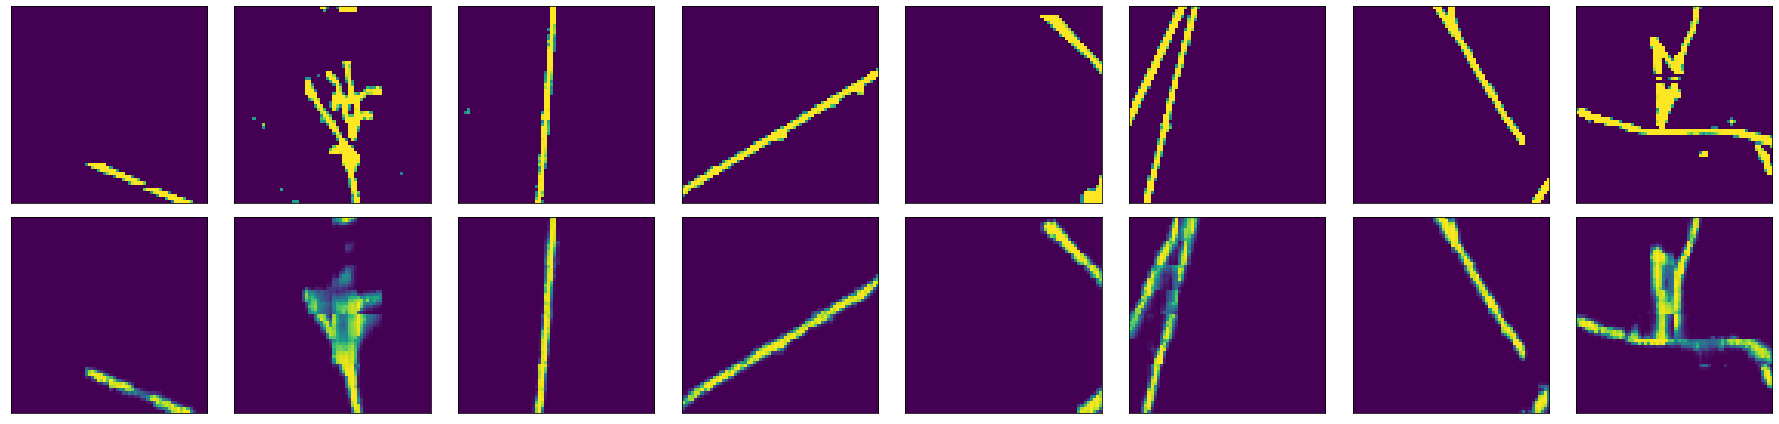

In [41]:
%matplotlib inline
# Setup figure
fig, axes = plt.subplots(nrows = 2, ncols = limit//2, sharex=True, sharey=True, figsize=(25,6))

# Set title
if 'mlp' in exp_path:
    m_label = 'AE'
else:
    m_label = 'Conv_AE'

# title = "{} model test samples using {}x{} dataset".format(m_label, im_dim, im_dim)
# fig.suptitle(title, color="white")

# Generate plot
for images, row in zip([test_ims, samples], axes):
    for img, ax in zip(images, row):
        img = np.reshape(img, (im_dim, im_dim))
        ax.imshow(img)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.tick_params(axis='x', colors='#443941')
        ax.tick_params(axis='y', colors='#443941')

fig.tight_layout()
# Save figure
plt.savefig("{}_model_test_samples_{}_dataset.png".format(m_label, im_dim), dpi=300, facecolor='#443941')

In [ ]:
# n_row = 2; n_col = limit//2

# fig, axes = plt.subplots(n_row, n_col)
# supTitle = "{} Model deploy samples using {}x{} dataset".format('AE', im_dim, im_dim)
# fig.suptitle(supTitle, color="white")

# img = None; test_num = limit; sample_num = limit
# for i in range(0, n_row):
#     for j in range(0, n_col):
#         if i == 0:
#             print(i, j, test_num)
#             img = axes[i,j].imshow( test_ims[test_num] )
#             test_num -= 1
#         else:
#             img = axes[i,j].imshow( samples[sample_num][0] )
#             sample_num -= 1
#         axes[i,j].spines['bottom'].set_color('white')
#         axes[i,j].spines['top'].set_color('white')
#         axes[i,j].spines['left'].set_color('white')
#         axes[i,j].spines['right'].set_color('white')
#         axes[i,j].xaxis.label.set_color('white')
#         axes[i,j].yaxis.label.set_color('white')
#         axes[i,j].get_xaxis().set_visible(False)
#         axes[i,j].get_yaxis().set_visible(False)
#         axes[i,j].tick_params(axis='x', colors='#443941')
#         axes[i,j].tick_params(axis='y', colors='#443941')

# # Colorbar
# # cbar_axes = fig.add_axes([0.9, 0.1, 0.03, 0.8])
# # cbar = plt.colorbar(img, cax=cbar_axes)
# # cbar.ax.yaxis.set_tick_params(color="white")
# # cbar.outline.set_edgecolor(color="white")
# # plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color="white")

# plt.savefig("{}_model_deploy_samples_{}_dataset.png".format('AE', im_dim), dpi=300, facecolor='#443941')